# Guía de clasificación bancaria — Churn de clientes

Este notebook guía permite analizar un conjunto de datos de clientes bancarios con el objetivo de predecir si un cliente abandona la entidad (`churn`: 1=abandona, 0=no).

El flujo contempla exploración y limpieza, selección automática de variables relevantes usando tests estadísticos, optimización de hiperparámetros usando GridSearchCV CON validación cruzada segura para datasets pequeños, y el ajuste y comparación de modelos árbol de decisión, SVM y random forest.

Las métricas empleadas serán accuracy, precision y recall.

In [20]:
# --- Carga de datos, librerías principales y preprocesamiento categórico ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ejemplo (reemplaza por tu archivo real, aquí es solo una mini-muestra):
df = pd.read_csv('churn_test_labeled.csv', index_col=False)


# Ajuste tipo categórico (importante para dummies correctos)
df['country'] = df['country'].astype('category')
df['gender'] = df['gender'].astype('category')
df = pd.get_dummies(df, columns=['country','gender'], drop_first=True)
df.head()

credit_score  age  tenure    balance  products_number  credit_card  \
0           713   48       1  163760.82                1            0   
1           502   30       4       0.00                2            1   
2           817   45       9  101207.75                1            0   
3           730   39       1  116537.60                1            0   
4           576   52       2  100549.43                2            1   

   active_member  estimated_salary  churn  country_Germany  country_Spain  \
0              0         157381.14      1            False           True   
1              1          66263.87      0            False          False   
2              0          88211.12      1             True          False   
3              0         145679.60      0            False          False   
4              1          16644.16      0            False           True   

   gender_Male  
0        False  
1         True  
2         True  
3         True  
4         True

## 1. Exploración y visualización inicial

In [21]:
# Inspección básica
df.info()
df.describe()
print('\nDistribución de la variable objetivo:')
print(df['churn'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      1000 non-null   int64  
 1   age               1000 non-null   int64  
 2   tenure            1000 non-null   int64  
 3   balance           1000 non-null   float64
 4   products_number   1000 non-null   int64  
 5   credit_card       1000 non-null   int64  
 6   active_member     1000 non-null   int64  
 7   estimated_salary  1000 non-null   float64
 8   churn             1000 non-null   int64  
 9   country_Germany   1000 non-null   bool   
 10  country_Spain     1000 non-null   bool   
 11  gender_Male       1000 non-null   bool   
dtypes: bool(3), float64(2), int64(7)
memory usage: 73.4 KB

Distribución de la variable objetivo:
churn
0    796
1    204
Name: count, dtype: int64


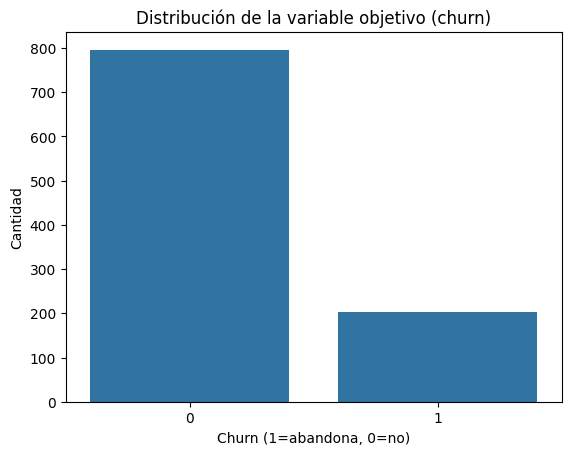

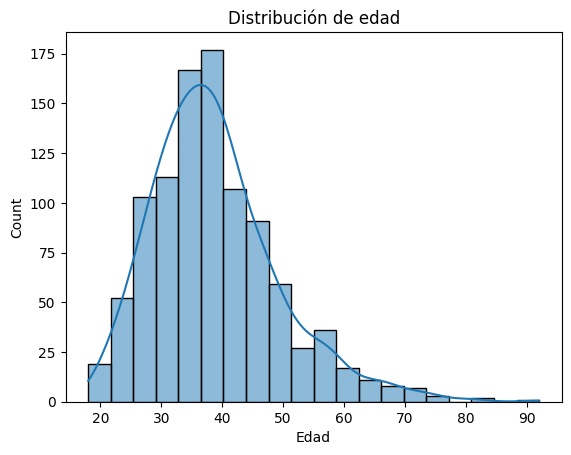

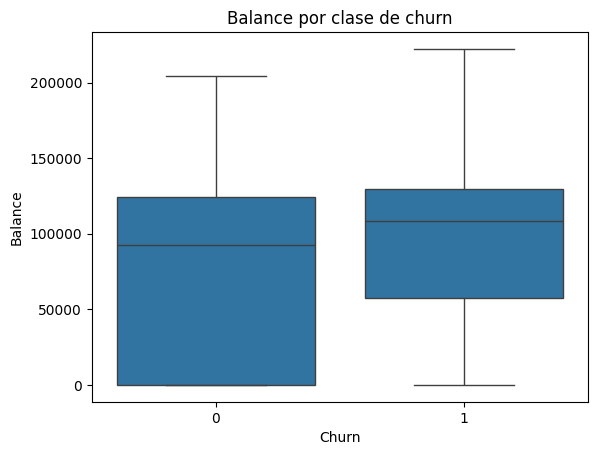

In [22]:
# Visualizaciones principales
sns.countplot(x='churn', data=df)
plt.title('Distribución de la variable objetivo (churn)')
plt.xlabel('Churn (1=abandona, 0=no)')
plt.ylabel('Cantidad')
plt.show()

sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribución de edad')
plt.xlabel('Edad')
plt.show()

sns.boxplot(x='churn', y='balance', data=df)
plt.title('Balance por clase de churn')
plt.xlabel('Churn')
plt.ylabel('Balance')
plt.show()

## 2. Selección automática de variables relevantes según tests estadísticos
Debido al tamaño del dataset, el umbral de p-value es flexible y el algoritmo es robusto para evitar quedarse sin variables.

In [23]:
# Selección automática robusta de variables
from scipy.stats import ks_2samp, chi2_contingency

num_vars = ['credit_score','age','tenure','balance','products_number','estimated_salary']
cat_vars = [col for col in df.columns if col.startswith('country_') or col.startswith('gender_') or col in ['products_number','credit_card','active_member']]

umbral_p = 0.4  # Flexibilidad para datasets pequeños
num_sel = []
for col in num_vars:
    class0 = df[df['churn']==0][col]
    class1 = df[df['churn']==1][col]
    ks_stat, ks_p = ks_2samp(class0, class1)
    if ks_p < umbral_p:
        num_sel.append(col)

cat_sel = []
for col in cat_vars:
    table = pd.crosstab(df[col], df['churn'])
    try:
        _, chi2_p, _, _ = chi2_contingency(table)
        if chi2_p < umbral_p:
            cat_sel.append(col)
    except:
        pass # Para categorías con una sola clase puede fallar

vars_final = list(set(num_sel + cat_sel))

if len(vars_final) == 0:
    print(f"Ninguna variable supera p < {umbral_p}. Usando todas las numéricas y dummies de país/género como fallback.")
    vars_final = num_vars + [col for col in df.columns if col.startswith('country_') or col.startswith('gender_')]
else:
    print(f"Variables seleccionadas (p < {umbral_p}):", vars_final)

X = df[vars_final]
y = df['churn']

Variables seleccionadas (p < 0.4): ['active_member', 'age', 'balance', 'gender_Male', 'country_Spain', 'country_Germany', 'products_number', 'credit_card']


## 3. División entrenamiento/prueba y escalado

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. GridSearchCV con validación cruzada segura para datasets pequeños

In [25]:
# GridSearchCV seguro: n_splits limitado por tamaño de la clase minoritaria
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

min_class_size = y_train.value_counts().min()
n_splits = min(5, min_class_size)
if n_splits < 2:
    n_splits = 2  # Asegura al menos 2 splits
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Árbol de decisión
params_tree = {
    "max_depth": [2, 4, 6, 8, 12, None],
    "min_samples_split": [2, 5, 10]
}
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params_tree, cv=cv, scoring='accuracy')
grid_tree.fit(X_train_scaled, y_train)
best_tree = grid_tree.best_estimator_
print("Mejor Árbol: ", grid_tree.best_params_)

# SVM
params_svm = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto"],
    "kernel": ["rbf", "linear"]
}
grid_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid=params_svm, cv=cv, scoring='accuracy')
grid_svm.fit(X_train_scaled, y_train)
best_svm = grid_svm.best_estimator_
print("Mejor SVM: ", grid_svm.best_params_)

# Random Forest
params_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 8, 12, None],
    "min_samples_split": [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=params_rf, cv=cv, scoring='accuracy')
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_
print("Mejor Random Forest: ", grid_rf.best_params_)

Mejor Árbol:  {'max_depth': 6, 'min_samples_split': 5}
Mejor SVM:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor Random Forest:  {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 50}


In [44]:
# Predicciones con mejores modelos
pred_tree = best_tree.predict(X_test_scaled)
pred_svm  = best_svm.predict(X_test_scaled)
pred_rf   = best_rf.predict(X_test_scaled)

preds_list = [pred_tree, pred_svm, pred_rf]

## 5. Comparación de accuracy, precision y recall

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, 

def print_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    print(f"{name:15}  Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}")

print_metrics('Árbol decisión', y_test, pred_tree)
print_metrics('SVM', y_test, pred_svm)
print_metrics('Random Forest', y_test, pred_rf)

Árbol decisión   Accuracy: 0.800  Precision: 0.508  Recall: 0.508
SVM              Accuracy: 0.830  Precision: 0.604  Recall: 0.475
Random Forest    Accuracy: 0.863  Precision: 0.812  Recall: 0.426


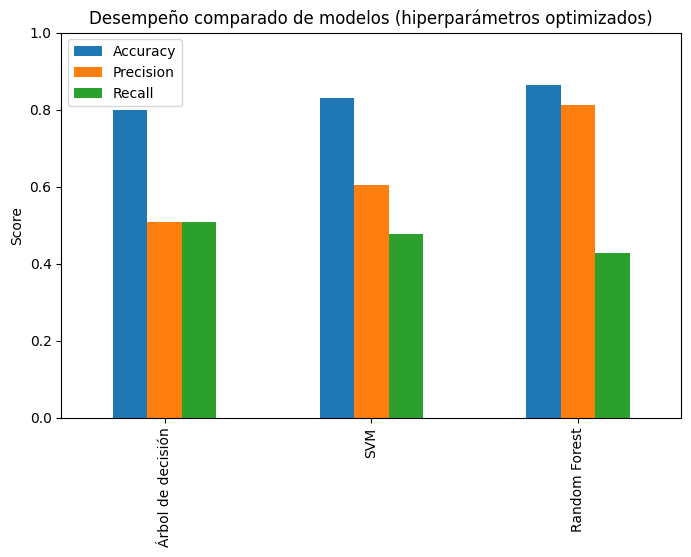

In [ ]:
# Gráfico comparativo de desempeño
metrics = ['Accuracy','Precision','Recall']
model_names = ['Árbol de decisión', 'SVM', 'Random Forest']
results = []
for preds in preds_list:
    results.append([
        accuracy_score(y_test, preds),
        precision_score(y_test, preds, zero_division=0),
        recall_score(y_test, preds, zero_division=0)
    ])
result_df = pd.DataFrame(results, columns=metrics, index=model_names)
result_df.plot(kind='bar', ylim=(0,1), figsize=(8,5))
plt.title('Desempeño comparado de modelos (hiperparámetros optimizados)')
plt.ylabel('Score')
plt.show()

Árbol de decisión
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       239
           1       0.51      0.51      0.51        61

    accuracy                           0.80       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.80      0.80      0.80       300



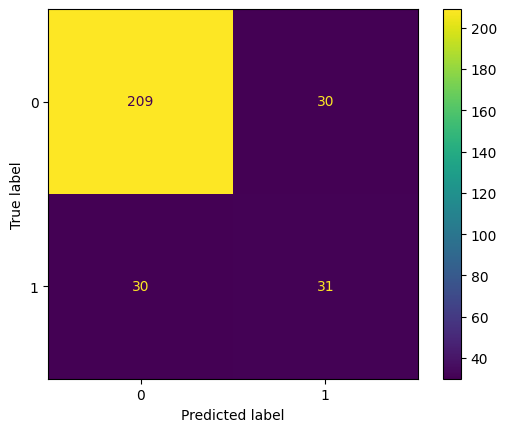

SVM
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       239
           1       0.60      0.48      0.53        61

    accuracy                           0.83       300
   macro avg       0.74      0.70      0.71       300
weighted avg       0.82      0.83      0.82       300



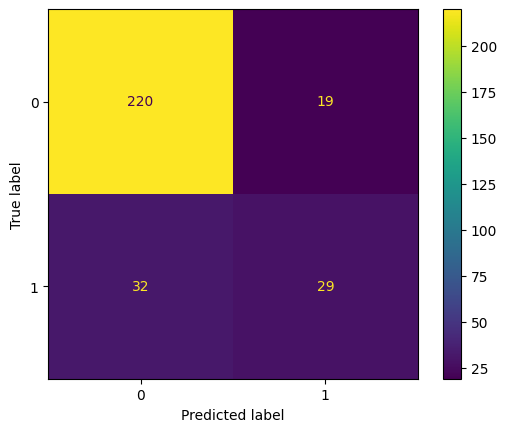

Random Forest
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       239
           1       0.81      0.43      0.56        61

    accuracy                           0.86       300
   macro avg       0.84      0.70      0.74       300
weighted avg       0.86      0.86      0.85       300



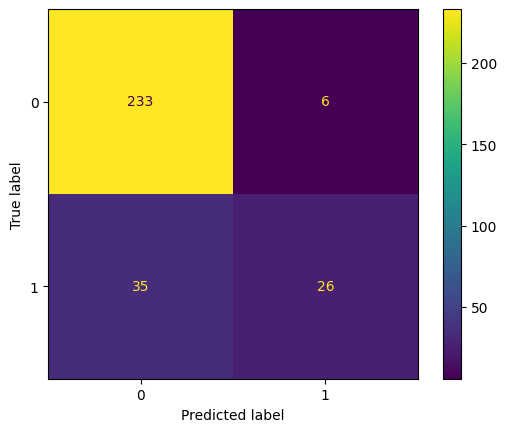

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

for preds, model in zip(preds_list, model_names):
    print(model)
    print(classification_report(y_test, preds))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.show()


# 6. Interpretabilidad con LIME

In [29]:
import lime
import lime.lime_tabular

#Instanciamos una explicación tabular para las dos clases.
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.to_numpy(), feature_names=X.columns, class_names=['No Churn','Churn'], discretize_continuous=True)

In [30]:
#Generamos los datos desescalados para poder mapearlos
x_original = scaler.inverse_transform(X_test_scaled)[0]
x_original


array([1.0000000e+00, 3.5000000e+01, 1.2592098e+05, 1.0000000e+00,
       1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00])

Vamos a seleccionar instancias (idx) para validar las predicciones usando LIME y cómo las características influeron en cada predicción local

In [31]:
idx = 36
instance = X_test_scaled[idx]

x_original = scaler.inverse_transform(X_test_scaled)[0]

print("Predicción SVM:", best_svm.predict([instance]))

exp_svm = explainer.explain_instance(instance, best_svm.predict_proba, num_features=6, num_samples=100)
print("Local fidelity (R²):", exp_svm.score)

exp_svm.domain_mapper.feature_values = [
    val for  val in x_original
]
exp_svm.show_in_notebook(show_table=True)


print("Predicción Random Forest:", best_rf.predict([instance]))

exp_rf = explainer.explain_instance(instance, best_rf.predict_proba, num_features=6, num_samples=100)
print("Local fidelity (R²):", exp_rf.score)

exp_rf.domain_mapper.feature_values = [
    val for  val in x_original
]

exp_rf.show_in_notebook(show_table=True)



Predicción SVM: [1]
Local fidelity (R²): 0.748491383196268


Predicción Random Forest: [1]
Local fidelity (R²): 0.9287210812384454


# 7. Interpretabilidad con SHAPLEY

## 7.1 Modelo de Random Forest

In [32]:
import shap
shap.initjs()

#Se generan las explicaciones para árboles con un subconjunto de datos.
explainer_rf = shap.TreeExplainer(best_rf, X_train_scaled, feature_names=X_train.columns)


c:\Users\jprey\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vamos a ejecutar el código para realizar las explicaciones sobre los datos de test

In [33]:
shap_values_rf = explainer_rf(X_test_scaled, check_additivity=False)
shap_values_rf.data=scaler.inverse_transform(X_test_scaled)


Relizamos un diagrama de enjambre y uno de fuerza para poder analizar los resultados

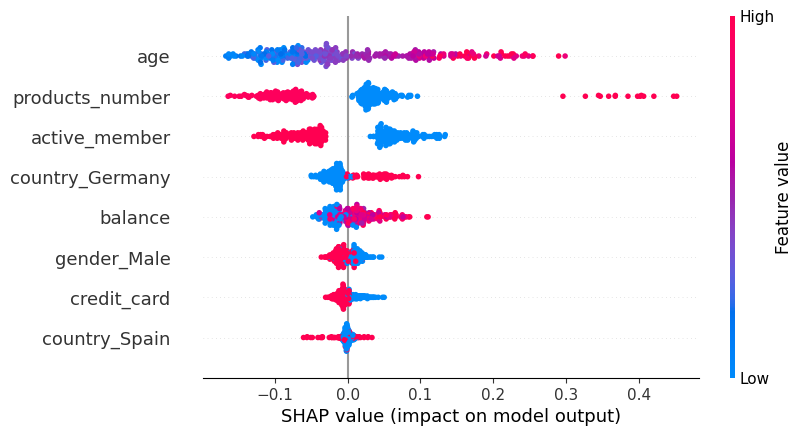

In [34]:
shap.plots.beeswarm(shap_values_rf[:,:,1])
shap.force_plot(shap_values_rf[:,:,1], X_test[:100], feature_names=X.columns)


Valor de la etiqueta en el dataset: 1
Valor predecido por el modelo: 1


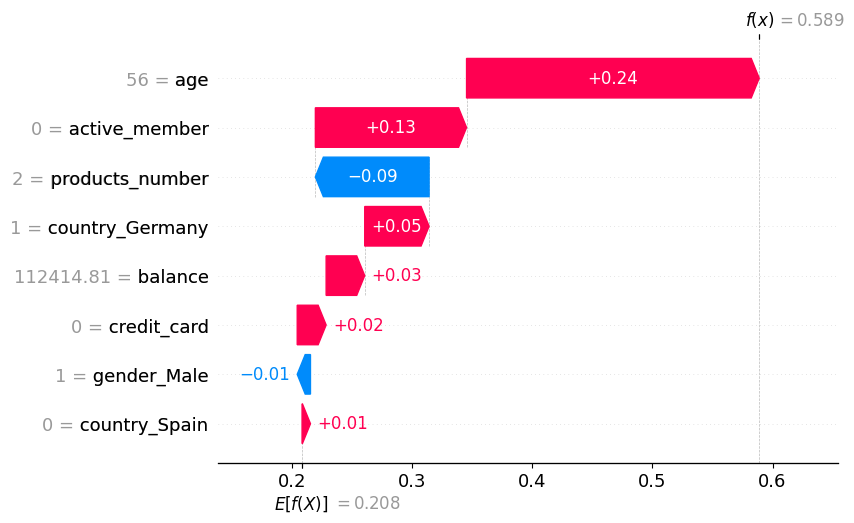

In [35]:
sample_index = 160    # seleccionamos la muetra
print("Valor de la etiqueta en el dataset:" ,y_test.to_numpy()[sample_index])
print("Valor predecido por el modelo:",pred_tree[sample_index])


shap.plots.waterfall(shap_values_rf[sample_index,:,1])

## 7.2 Modelo de SVM

En este caso, inicializamos un KernelExplainer (agnóstico de modelo) y lo corremos sobre una muestra de los datos

In [36]:
explainer_svm = shap.KernelExplainer(best_svm.predict_proba, X_train_scaled[:200], feature_names=X_train.columns)
shap_values_svm = explainer_svm(X_test_scaled)
shap_values_svm.data=scaler.inverse_transform(X_test_scaled)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [04:51<00:00,  1.03it/s]


Realizamos los diagramas de enjambre y de fuerza.

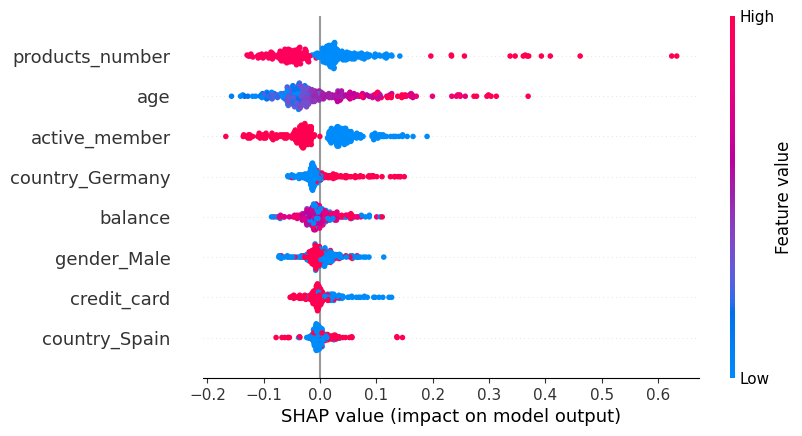

In [37]:
shap.plots.beeswarm(shap_values_svm[:,:,1])
shap.force_plot(shap_values_svm[:,:,1], X_test[:100], feature_names=X.columns)


Finalmente analizamos las predicciones individuales

Valor de la etiqueta en el dataset: 1
Valor predecido por el modelo: 1


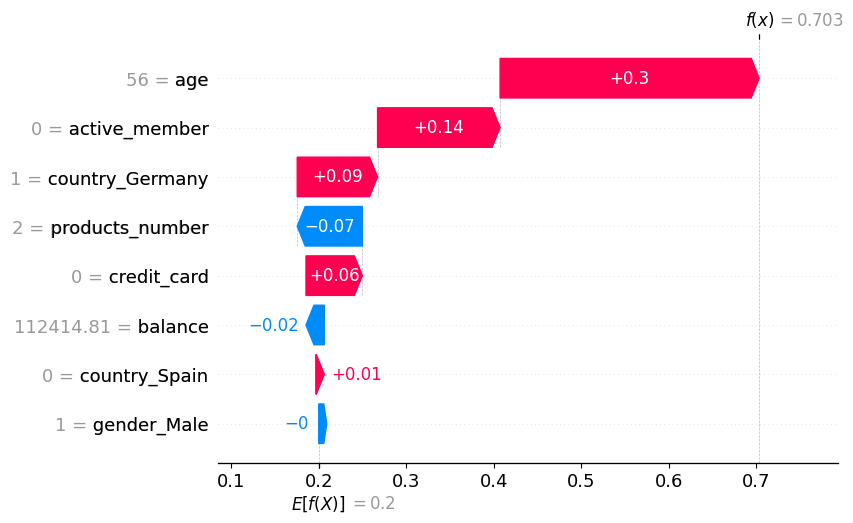

In [38]:
sample_index = 160    # seleccionamos la muetra
print("Valor de la etiqueta en el dataset:" ,y_test.to_numpy()[sample_index])
print("Valor predecido por el modelo:",pred_tree[sample_index])


shap.plots.waterfall(shap_values_svm[sample_index,:,1])

## 8. Reflexión y ejercicios

1. Grafique la matriz de confusión para ambos modelos y compárelas.
2. Implemente balanceo de datos (SMOTE) sobre los datos de entrenamiento únicamente
3. Implemente las modificaciones sobre los modelos en el anterior ejercicio. Compare las explicaciones de LIME para las mismas instancias con la de los modelos anteriores. ¿Hubo variaciones significativas?
4. Implemente las modificaciones sobre los modelos en el anterior ejercicio. Compare las explicaciones de SHAPLEY para todas las instancias y para las mismas instancias particulares con la de los modelos anteriores. ¿Hubo variaciones significativas?
5. Analice en particular instancias interesantes (en dónde se equivocó el clasificador y genere una explicación de en dónde radica la dificultad para la predicción del mismo)
